In [8]:
# PyTorch imports
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

# Random seed 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# PyTorch version 및 GPU 확인
print(torch.__version__)
if torch.cuda.is_available():
    print(f"CUDA Available: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS Available (Apple Silicon GPU)")
else:
    print("No GPU available")

2.3.0
MPS Available (Apple Silicon GPU)


In [9]:
data_dir = "/Users/jian_lee/Desktop/aiffel/data/bert"
model_dir = "/Users/jian_lee/Desktop/aiffel/data/bert"

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

## mask 생성

In [10]:
# 특수 토큰 정의
mask_token = "[MASK]"

# 예제 문장
sample_text = "BERT는 트랜스포머 모델을 기반으로 하는 자연어 처리 모델입니다."

# SentencePiece 토큰화
tokens = vocab.encode(sample_text, out_type=str)  # 입력 문장을 SentencePiece를 사용해 토큰화 (서브워드 단위)

# 서브워드를 단어 단위로 묶기
# SentencePiece는 단어를 서브워드로 분리하기 때문에, 이를 원래 단어 단위로 다시 합친다.
words = []
current_word = ""

for token in tokens:
    if token.startswith("▁"):  # 새로운 단어가 시작되는 경우 (▁는 SentencePiece의 단어 구분 기호)
        if current_word:
            words.append(current_word)  # 이전 단어를 리스트에 추가
        current_word = token  # 새로운 단어 시작
    else:
        current_word += token  # 서브워드인 경우 이전 토큰에 이어 붙인다.

if current_word:  # 마지막 단어를 리스트에 추가
    words.append(current_word)

# 단어 단위 마스킹 적용
# 전체 단어 중 15%를 랜덤하게 선택하여 마스킹할 대상 선정
num_mask = max(1, int(len(words) * 0.15))  # 최소 1개의 단어는 마스킹해야 함
mask_indices = random.sample(range(len(words)), num_mask)  # 랜덤하게 마스킹할 단어 인덱스 선택

for i in mask_indices:
    prob = np.random.rand()  # 0과 1 사이의 랜덤한 확률 값 생성
    if prob < 0.8:
        words[i] = mask_token  # 80% 확률로 [MASK] 토큰으로 변경
    elif prob < 0.9:
        # 랜덤한 단어를 선택할 때, 범위를 올바르게 설정하여 이상한 문자 방지
        random_word_id = random.randint(0, vocab.get_piece_size() - 1)  # 랜덤한 단어 ID 선택
        words[i] = vocab.id_to_piece(random_word_id)  # 10% 확률로 랜덤한 단어로 대체
    # 나머지 10%는 원래 단어를 유지 (변경 없음)

# 마스킹된 문장을 다시 SentencePiece 토큰으로 변환
masked_sentence = " ".join(words)  # 리스트를 공백을 기준으로 하나의 문장으로 변환
masked_tokens = vocab.encode(masked_sentence, out_type=str)  # 다시 SentencePiece 토큰화

# 최종 출력
print("원본 문장:", sample_text)  # 원본 문장 출력
print("토큰화된 문장:", masked_tokens)  # 마스킹이 적용된 토큰화된 문장 출력

원본 문장: BERT는 트랜스포머 모델을 기반으로 하는 자연어 처리 모델입니다.
토큰화된 문장: ['▁B', 'E', 'R', 'T', '는', '▁트', '랜', '스', '포', '머', '▁모델', '을', '▁기반', '으로', '▁하는', '▁자연', '어', '▁처리', '▁', '[MASK]']


In [11]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 조정하여 max_seq 이하로 맞추는 함수.
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            tokens_a.pop(0)  # tokens_a 앞에서 삭제
        else:
            tokens_b.pop()  # tokens_b 뒤에서 삭제

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    문서를 기반으로 BERT의 Pretrain 데이터(NSP + MLM)를 생성하는 함수.
    """
    max_seq = n_seq - 3  # [CLS]와 두 개의 [SEP]를 고려한 최대 토큰 길이
    instances = []

    current_chunk = []
    current_length = 0

    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])

        if len(current_chunk) > 1 and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if len(current_chunk) > 2:
                a_end = random.randrange(1, len(current_chunk))

            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])

            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # 50% 확률로 NSP의 False 케이스 생성
            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1

            trim_tokens(tokens_a, tokens_b, max_seq)

            assert 0 < len(tokens_a) and 0 < len(tokens_b)

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instances.append((tokens, segment, is_next, mask_idx, mask_label))

            current_chunk = []
            current_length = 0

    return instances

def create_pretrain_mask(tokens, mask_count, vocab_list):
    """
    MLM을 위한 마스킹 함수.
    """
    masked_tokens = tokens[:]
    mask_indices = np.random.choice(len(tokens), mask_count, replace=False)
    mask_label = {}

    for idx in mask_indices:
        if tokens[idx] in ["[CLS]", "[SEP]"]:
            continue

        prob = np.random.rand()

        if prob < 0.8:
            masked_tokens[idx] = "[MASK]"
        elif prob < 0.9:
            masked_tokens[idx] = random.choice(vocab_list)

        mask_label[idx] = tokens[idx]

    return masked_tokens, list(mask_label.keys()), list(mask_label.values())

def decode_tokens(tokens):
    """
    SentencePiece로 토큰화된 리스트를 다시 문장으로 복원하는 함수.
    """
    return "".join([token.replace("▁", " ") for token in tokens])

# n_test_seq 설정
n_test_seq = 64
vocab_list = [vocab.id_to_piece(i) for i in range(vocab.get_piece_size())]

# 예제 문장 18개 활용
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번째에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통과 사론푼에
손바닥 위에 기쁨의 눈물이 흘러
걸쭉한 목에 모주 한잔을 적셔
몇 달 표 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 가질어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말란 내 옆에 있어 달라던
그리고 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# 줄 단위 Tokenization
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]

# Pretrain 데이터 생성
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 확인
for instance in instances:
    tokens, segment, is_next, mask_idx, mask_label = instance
    
    print(f"\n**NSP Label:** {'True' if is_next == 1 else 'False'}")
    print(f"**Segment ID:** {segment}")
    print(f"**Masked Token Index:** {mask_idx}")
    print(f"**Original Masked Tokens:** {mask_label}")

    print("\n**Decoded Sentence:**")
    print("문장 A:", decode_tokens(tokens[:tokens.index("[SEP]")]))
    print("문장 B:", decode_tokens(tokens[tokens.index("[SEP]")+1:tokens.index("[SEP]", tokens.index("[SEP]")+1)]))
    print("-" * 80)


**NSP Label:** False
**Segment ID:** [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
**Masked Token Index:** [22, 33, 54, 8, 6, 58, 35, 20, 4]
**Original Masked Tokens:** ['▁전', '▁백', '추', '이', '▁손', '▁내', '과', '▁오', '왠']

**Decoded Sentence:**
문장 A: [CLS]날은 [MASK]지[MASK]님[MASK] 많아 첫 번째에 삼십 전 둘째 번[MASK]십 전 오랜만에 받아보는 십 전짜리 백통[MASK] 사론푼에 손바닥 위에 기쁨의 눈물이 흘러
문장 B:  추적[MASK]적 비가[MASK]리는 날이었어
--------------------------------------------------------------------------------

**NSP Label:** False
**Segment ID:** [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
**Masked Token Index:** [60, 5, 16, 6, 51, 27, 58, 49, 55]
**Original Masked Tokens:** ['▁있어', '리가', '리가', '▁가', '탕', '을', '▁살', '던', '을']

**Decoded Sen

In [12]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """
    BERT Pretrain 데이터 생성 및 JSON 저장
    
    :param vocab: SentencePiece vocab 객체
    :param in_file: 입력 파일 (kowiki.txt)
    :param out_file: 출력 JSON 파일 (bert_pre_train.json)
    :param n_seq: 최대 시퀀스 길이
    :param mask_prob: MLM 마스킹 확률 (default: 15%)
    """
    
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            # NumPy 타입을 JSON 직렬화 가능하도록 변환
            instance = {
                "tokens": instance[0],  
                "segment": instance[1],  
                "is_next": int(instance[2]),  # numpy.int64 → Python int
                "mask_idx": list(map(int, instance[3])),  # numpy array → list of int
                "mask_label": list(map(str, instance[4]))  # numpy array → list of str
            }
            out_f.write(json.dumps(instance, ensure_ascii=False) + "\n")
    
    # 특수문자 및 unknown 토큰을 제외한 vocab 리스트 생성
    vocab_list = [vocab.id_to_piece(i) for i in range(7, len(vocab)) if not vocab.is_unknown(i)]
    
    # 파일 전체 라인 수 확인
    line_cnt = sum(1 for _ in open(in_file, "r"))

    # 문서 단위로 데이터 생성 및 저장
    with open(in_file, "r") as in_f, open(out_file, "w") as out_f:
        doc = []
        for line in tqdm(in_f, total=line_cnt):
            line = line.strip()
            
            # 빈 줄이면 새로운 문서 시작
            if line == "":
                if len(doc) > 0:
                    save_pretrain_instances(out_f, doc)
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(line)
                if len(pieces) > 0:
                    doc.append(pieces)
        
        # 마지막 문서 저장
        if len(doc) > 0:
            save_pretrain_instances(out_f, doc)


def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    JSON으로 저장된 Pretrain 데이터를 np.memmap을 사용해 로딩
    
    :param vocab: SentencePiece vocab 객체
    :param filename: JSON 데이터 파일
    :param n_seq: 시퀀스 길이
    :param count: 로드할 데이터 개수 (None이면 전체 로드)
    :return: np.memmap 형태의 BERT 학습 데이터셋
    """
    
    # 전체 라인 수 확인
    total = sum(1 for _ in open(filename, "r"))
    if count is not None:
        total = min(total, count)

    # np.memmap으로 대용량 데이터 저장
    enc_tokens = np.memmap("enc_tokens.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap("segments.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap("labels_nsp.memmap", mode="w+", dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap("labels_mlm.memmap", mode="w+", dtype=np.int32, shape=(total, n_seq))

    # JSON 파일 읽어서 np.memmap에 저장
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if i >= total:
                print("Data Load Early Stop:", total)
                break

            data = json.loads(line)

            # 토큰 변환
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))

            # 세그먼트 변환
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            # NSP 라벨
            label_nsp = data["is_next"]

            # MLM 라벨
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, fill_value=0, dtype=np.int32)
            label_mlm[mask_idx] = mask_label

            # 데이터 저장
            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return enc_tokens, segments, labels_nsp, labels_mlm


# 데이터 생성 실행 
base_path = "/Users/jian_lee/Desktop/aiffel/data/bert"
corpus_file = "/Users/jian_lee/Desktop/aiffel/data/bert/kowiki.txt"
pretrain_json_path = f"{base_path}/bert_pre_train.json"

# BERT Pretrain 데이터 생성 및 JSON 저장
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

# np.memmap을 사용하여 데이터 로딩
pre_train_inputs, pre_train_segments, pre_train_nsp, pre_train_mlm = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

# 첫 번째 데이터 및 마지막 데이터 확인
print(pre_train_inputs[0], pre_train_inputs[-1])
print(pre_train_segments[0], pre_train_segments[-1])
print(pre_train_nsp[0], pre_train_nsp[-1])
print(pre_train_mlm[0], pre_train_mlm[-1])

  0%|          | 0/3957761 [00:00<?, ?it/s]

  0%|          | 0/128000 [00:00<?, ?it/s]

Data Load Early Stop: 128000
[   5   18 3686  207 3714    4 3324 1042  136 3610 3686 3718  207 3714
   37 3418  416  810 3666 3625  131 3662    6 3629  203  241 3602    6
    6  788  243   49 3632    6  663 2842 3682 3682 3625  203 3008 3625
 3616    6 3599   18 3686  207 3714 3602 1755 3630 3646  630 3714 3565
 3835  429 3740 3628 3626    6   10 1605 3599 1755 3630   41 3644  830
    6    6   52 3599   13   81   87 1501 2247   25 3779 3873 3667 3631
 3813 3873    6 3636 3779 3601    6 3725 1232   33   52 3599  479 3652
 3625  243 2780   14 1509    6 3877  414  165    6 4290 3873 3703 3683
  593   21 5007    6 1927 3607  813   17 3599  307  587  931  103 4313
 4290    4] [   5  848 3784 3833    8 3637 3676    4  848    6 1931   58 3676  416
 2316 3619 3625 3617 3744 4335   12 3625 3616  175 3662    7 3629  203
  578 3652 3625 3617 4148 3665    6 3625 3616  131 3662  342 3629 3616
 3602  176  334  829 1115    6    6 4148 3451 1633  375    6    6 3608
    6 3423  765  815 3604  752 3608 

In [16]:
# GELU Activation Function
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))

# Weight Initialization
def kernel_initializer(module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, mean=0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.trunc_normal_(module.weight, mean=0, std=0.02)

# Config Class (JSON 형태로 사용)
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)
    
    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config_dict = json.load(f)
        return cls(config_dict)

# Pad Mask
def get_pad_mask(tokens, pad_idx=0):
    return (tokens == pad_idx).unsqueeze(1)  # (batch, 1, seq_len)

# Ahead Mask (Look-ahead Mask)
def get_ahead_mask(seq_len):
    return torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

# Shared Word Embedding
class SharedEmbedding(nn.Module):
    def __init__(self, config):
        super(SharedEmbedding, self).__init__()
        self.embedding = nn.Embedding(config.n_vocab, config.d_model)
        self.embedding.apply(kernel_initializer)

    def forward(self, x):
        return self.embedding(x)

# Position Embedding
class PositionEmbedding(nn.Module):
    def __init__(self, config):
        super(PositionEmbedding, self).__init__()
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        self.embedding.apply(kernel_initializer)

    def forward(self, x):
        position = torch.arange(x.size(1), device=x.device).expand(x.size(0), -1)
        return self.embedding(position)

# Scaled Dot Product Attention
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        attn_score = torch.matmul(Q, K.transpose(-1, -2))  # (batch, head, seq_len, seq_len)
        scale = torch.sqrt(torch.tensor(K.size(-1), dtype=torch.float32, device=Q.device))
        
        attn_prob = attn_score / scale
        attn_prob = attn_prob.masked_fill(attn_mask, float('-inf'))  # Mask 적용 (True인 곳에 -inf)

        attn_prob = F.softmax(attn_prob, dim=-1)  # Softmax 적용
        return torch.matmul(attn_prob, V)

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.attention = ScaleDotProductAttention()
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)

        Q = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)

        # attn_mask 크기 조정
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)  # (batch, n_head, seq_len, seq_len)

        attn_out = self.attention(Q, K, V, attn_mask)
        attn_out = attn_out.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)

        return self.W_O(attn_out)
# Feed Forward Network
class PositionWiseFeedForward(nn.Module):
    def __init__(self, config):
        super(PositionWiseFeedForward, self).__init__()
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)

    def forward(self, x):
        return self.W_2(gelu(self.W_1(x)))

# Transformer Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model)

    def forward(self, x, attn_mask):
        attn_out = self.self_attention(x, x, x, attn_mask)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        return self.norm2(x + ffn_out)

# BERT Model
class BERT(nn.Module):
    def __init__(self, config):
        super(BERT, self).__init__()
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.encoder_layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_layer)])

    def forward(self, tokens):
        x = self.embedding(tokens) + self.position(tokens)
        attn_mask = get_pad_mask(tokens)
        for layer in self.encoder_layers:
            x = layer(x, attn_mask)
        return x

# Pretrain Model
class BERTPretrainModel(nn.Module):
    def __init__(self, config):
        super(BERTPretrainModel, self).__init__()
        self.bert = BERT(config)
        self.cls_head = nn.Linear(config.d_model, config.n_vocab)
        self.nsp_head = nn.Linear(config.d_model, 2)

    def forward(self, tokens):
        x = self.bert(tokens)
        logits_mlm = self.cls_head(x)  # Masked LM
        logits_nsp = self.nsp_head(x[:, 0, :])  # Next Sentence Prediction
        return logits_mlm, logits_nsp

# Config 설정
config_dict = {
    "d_model": 256,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 1024,
    "n_vocab": 32000,
    "n_seq": 128,
    "n_layer": 6
}
config = Config(config_dict)

# 디바이스 설정 (MPS -> CUDA -> CPU 우선순위)
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")
print(f"Using device: {device}")

# 모델 생성 및 디바이스 이동
model = BERTPretrainModel(config).to(device)

# 모델이 올라간 디바이스 확인 후 데이터 이동
tokens = torch.randint(0, config.n_vocab, (2, config.n_seq), device=device)  # 임의의 입력
logits_mlm, logits_nsp = model(tokens)

print("MLM Shape:", logits_mlm.shape)  # (batch, seq_len, vocab_size)
print("NSP Shape:", logits_nsp.shape)  # (batch, 2)

Using device: mps
MLM Shape: torch.Size([2, 128, 32000])
NSP Shape: torch.Size([2, 2])


Using device: mps


Epoch 1/4:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 1/4 완료 - Avg Loss: 207.6702, Avg Acc: 0.0000


Epoch 2/4:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 2/4 완료 - Avg Loss: 207.4735, Avg Acc: 0.0000


Epoch 3/4:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 3/4 완료 - Avg Loss: 207.4685, Avg Acc: 0.0000


Epoch 4/4:   0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 4/4 완료 - Avg Loss: 207.4675, Avg Acc: 0.0000


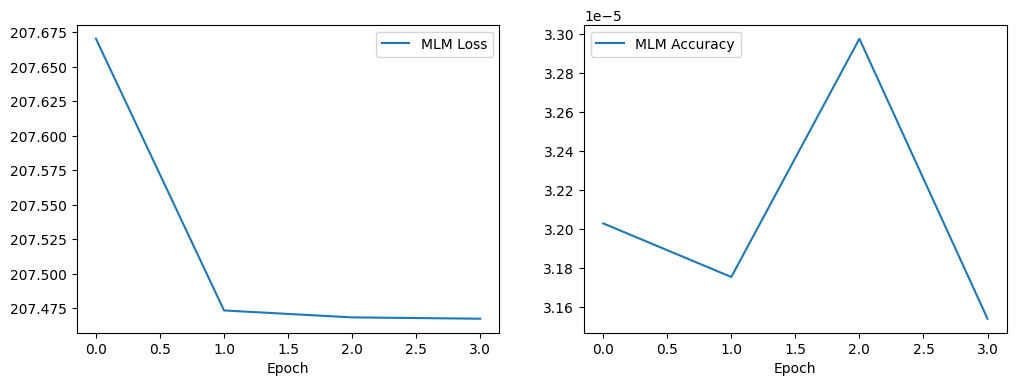

In [22]:
# Loss function for MLM (Masked Language Modeling)
def mlm_loss(y_true, y_pred):
    loss_fn = nn.CrossEntropyLoss(ignore_index=0, reduction='none')
    loss = loss_fn(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))
    return loss.mean() * 20  # MLM loss를 더 강조

# Accuracy function for MLM
def mlm_acc(y_true, y_pred):
    with torch.no_grad():
        y_pred_class = y_pred.argmax(dim=-1)
        matches = (y_true == y_pred_class).float()
        mask = (y_true != 0).float()
        accuracy = (matches * mask).sum() / mask.sum()
    return accuracy.item()

# Learning Rate Scheduler (Warmup + Cosine Annealing)
class CosineSchedule:
    def __init__(self, train_steps, warmup_steps=2000, max_lr=2.5e-4):
        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr
    
    def get_lr(self, step_num):
        if step_num <= self.warmup_steps:
            return self.max_lr * step_num / self.warmup_steps
        progress = (step_num - self.warmup_steps) / (self.train_steps - self.warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress)) * self.max_lr

# Device 설정 (CUDA, MPS, CPU)
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")

# 모델 생성 및 device 할당
model = BERTPretrainModel(config).to(device)

print(f"Using device: {device}")

# Optimizer & Scheduler
batch_size = 64
epochs = 4
train_steps = math.ceil(128000 / batch_size) * epochs  # 128000개 샘플 사용
scheduler = CosineSchedule(train_steps)
optimizer = optim.Adam(model.parameters(), lr=scheduler.get_lr(0), betas=(0.9, 0.98), eps=1e-9)

# Training loop with tqdm
loss_history, acc_history = [], []
for epoch in range(epochs):
    model.train()
    total_loss, total_acc = 0, 0
    
    with tqdm(range(train_steps), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for step in pbar:
            # 모델이 위치한 디바이스를 자동으로 가져와 데이터를 해당 디바이스로 이동
            device = next(model.parameters()).device  
            
            tokens = torch.randint(0, config.n_vocab, (batch_size, config.n_seq)).to(device)
            labels_mlm = torch.randint(0, config.n_vocab, (batch_size, config.n_seq)).to(device)
            
            optimizer.zero_grad()
            logits_mlm, logits_nsp = model(tokens)
            loss = mlm_loss(labels_mlm, logits_mlm)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_acc += mlm_acc(labels_mlm, logits_mlm)
            optimizer.param_groups[0]['lr'] = scheduler.get_lr(step)
            
            # tqdm 진행바에 실시간 Loss, Accuracy 업데이트
            pbar.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{mlm_acc(labels_mlm, logits_mlm):.4f}"})

    avg_loss = total_loss / train_steps
    avg_acc = total_acc / train_steps
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
    print(f"Epoch {epoch+1}/{epochs} 완료 - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

# Plot loss & accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='MLM Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='MLM Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()